In [118]:
# Third-party
from astropy.table import Table
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('apw-notebook')
%matplotlib inline
import tqdm

# Argument 1:

_It's improbable that 2 G-type stars will be so close to each other, both in 3D position and 2D sky separation._

This doesn't even take into account the velocities, we'll just look at positions; we can therefore make this argument purely based on the number density of G-type stars in the solar neighborhood. [Bovy 2017](https://arxiv.org/abs/1704.05063) computes the number density of stars in bins of spectral subtype in cylinders centered on the Sun. For G-stars, he uses a cylinder with $R = 150~{\rm pc}$, and fits the vertical number density with a mixture of ${\rm sech}(z)^2$ functions with two different scale heights:
$$
    \nu_*(z) = n \, \left[(1-\alpha)\,{\rm sech}(\frac{z}{2\,z_d})^2 + 
        \alpha\,{\rm sech}(\frac{z}{2\,z_{d,2}})^2\right]
$$
where $n$ is the midplane density, and I've assumed the Sun is in the midplane, $z_\odot = 0$. He finds that for most stars in TGAS, within $4\,z_d$, they are well fit when $\alpha=0$, so let's assume that as well.

From his fits, he finds that the total number density in G0–G3 dwarfs and the mean vertical scale-length is:
$$
\begin{align}
    n_{\rm G0} &= 4.1 \times 10^{-4} \, {\rm pc}^{-3}\\
    z_{d,G0} &= 108~{\rm pc}\\
    n_{\rm G2} &= 4.76 \times 10^{-4} \, {\rm pc}^{-3}\\
    z_{d,G2} &= 123~{\rm pc}
\end{align}
$$

With these numbers, after integrating the number density over the full cylinder:
$$
\begin{align}
    N &= \int_{-\infty}^{\infty} {\rm d}z \int_0^{2\pi}{\rm d}\phi \int_0^{150} {\rm d}R \, n \, R \, {\rm sech}(\frac{z}{2\,z_d})^2\\
    N_{G0} &\approx 1.3 \times 10^4\\
    N_{G2} &\approx 1.7 \times 10^4
\end{align}
$$

Let's densely sample from this density distribution (assuming uniform in $x$ and $y$), and ask: (a) what is the rate of getting a pair of G-type stars with sky separation $< 0.01~{\rm pc}$, and (b) what is the rate of getting a pair of G-type stars with 3D separation $<1~{\rm pc}$?

In [56]:
zd = 150. # pc

N_G0 = 13000
zd_G0 = 108. # pc

N_G2 = 17000
zd_G2 = 123. # pc

In [46]:
def dens_z(z, zd):
    return 1 / np.cosh(z / (2*zd))**2

In [50]:
def get_xyz(zd, size=1):
    """ Generate stellar positions using Bovy's number density model """
    
    # Cylindrical radius (heliocentric) used by Bovy for G stars
    R_G = 150 # pc
    
    # iteratively rejection-sample to get z values:
    z_samples = np.array([])
    while len(z_samples) < size:
        zs = np.random.uniform(0, 10*zd, size=size*100)
        us = np.random.uniform(0, 1, size=zs.size)
        _z_samples = zs[us < dens_z(zs, zd)]
        _z_samples = _z_samples * np.random.choice([-1, 1], size=_z_samples.size)
        z_samples = np.concatenate((z_samples, _z_samples))
        
    if len(z_samples) > size:
        z_samples = z_samples[:size]
        
    # generate uniform samples in x, y in the cylindrical disk
    R = R_G * np.sqrt(np.random.uniform(size=size))
    phi = np.random.uniform(0, 2*np.pi, size=size)
    x = R*np.cos(phi)
    y = R*np.sin(phi)
    
    return coord.CartesianRepresentation(x=x*u.pc, y=y*u.pc, 
                                         z=z_samples*u.pc)

First just test generating a bunch of G0 stars:

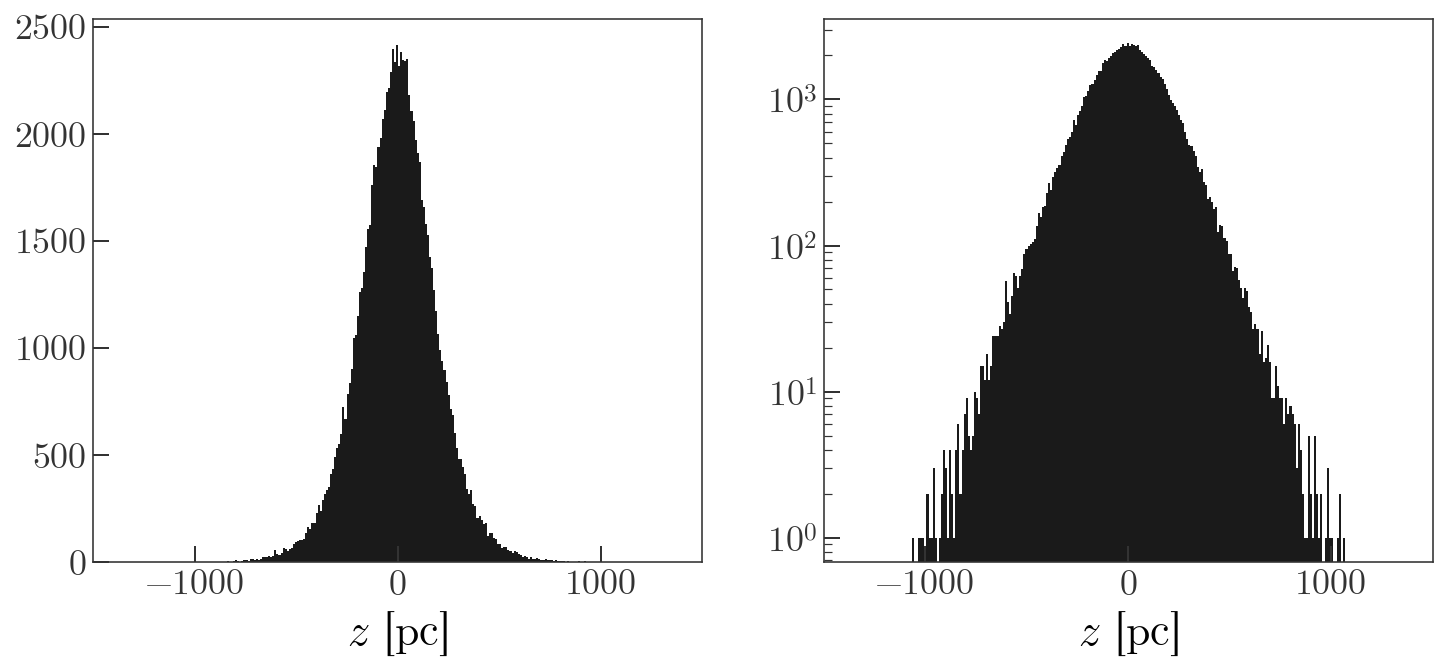

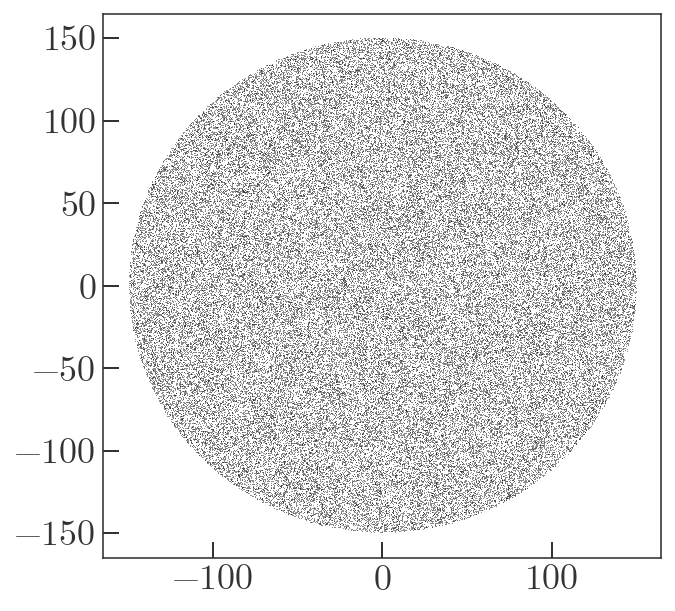

In [55]:
xyz = get_xyz(zd=108., size=100000)

# z distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
axes[0].hist(xyz.z.value, bins='auto');
axes[1].hist(xyz.z.value, bins='auto');
axes[1].set_yscale('log')

axes[0].set_xlabel('$z$ [pc]')
axes[1].set_xlabel('$z$ [pc]')

axes[0].set_xlim(-1500, 1500)

# x,y distribution
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(xyz.x.value, xyz.y.value, marker=',', alpha=0.5, linestyle='none')

Now we iterate over realizations and generate samples of G0 and G2 stars in the solar neighborhood. We use a kd-tree to find the nearest neighbor when matching the two sets of positions and compute the angular separation and 3D distance between the closest pairs of G0-G2 stars:

In [68]:
N_iter = 128 # number of realizations / experiments

# keep track of how many pairs have separations below:
N_2arcmins = []
N_1pcs = []

for i in tqdm.tqdm(range(N_iter)):
    xyz_G0 = get_xyz(zd=zd_G0, size=N_G0)
    xyz_G2 = get_xyz(zd=zd_G2, size=N_G2)
    _, sep2d, dist3d = coord.match_coordinates_3d(coord.ICRS(xyz_G0), coord.ICRS(xyz_G2))
    
    N_2arcmins.append((sep2d < 2*u.arcmin).sum())
    N_1pcs.append(((dist3d < 1*u.pc) & (sep2d < 2*u.arcmin)).sum())
    
N_2arcmins = np.array(N_2arcmins)
N_1pcs = np.array(N_1pcs)

100%|██████████| 128/128 [00:35<00:00,  3.90it/s]


In [80]:
print("Fraction of pairs with sep2d < 2': {0:.1e} +\- {1:.1e}"
      .format(np.mean(N_2arcmins) / len(xyz), np.std(N_2arcmins) / len(xyz)))
print("Fraction of pairs with sep2d < 2' and dist3d < 1 pc: {0:.1e} +\- {1:.1e}"
      .format(np.mean(N_1pcs) / len(xyz), np.std(N_1pcs / len(xyz))))

Fraction of pairs with sep2d < 2': 2.5e-05 +\- 1.5e-05
Fraction of pairs with sep2d < 2' and dist3d < 1 pc: 2.5e-06 +\- 4.8e-06


---

# Argument 2:

_It's improbable that 2 4 Gyr-old G-type stars will have such similar velocities._

This doesn't take into account the positions, which are very close given the typical spacing of G0–G2 pairs.

...

From [Nordstrom et al. 2004](https://www.aanda.org/articles/aa/pdf/2004/18/aa0959.pdf), at 4 Gyr:
$$
\sigma_U \approx 30~{\rm km}~{\rm s}^{-1}\\
\sigma_V \approx 20~{\rm km}~{\rm s}^{-1}\\
\sigma_W \approx 15~{\rm km}~{\rm s}^{-1}
$$

In [85]:
from scipy.spatial import cKDTree

In [ ]:
dist, idx = kdt.query(matchflatxyz.T, nthneighbor)

In [113]:
sigma_N04 = [30, 20, 15.]
v_G0 = np.random.normal(0, sigma_N04, (13000, 3)) 
v_G2 = np.random.normal(0, sigma_N04, (17000, 3))

In [181]:
# kdt = cKDTree(v)
# v_diff, idx = kdt.query(v, k=2)

# v_diff = v_diff[:,1]
# idx = idx[:,1]

In [182]:
# (v_diff < 2).sum() / len(v_diff)

In [180]:
# v_G0[idx[0,0]], v_G2[0]

# Argument 3:

_All other bright stars with similar colors and separations are known binaries._

Note: I haven't done the color cut yet; just the magnitude and distance cuts.

In [119]:
tgas = Table.read('../../gaia-comoving-stars/data/stacked_tgas.fits')

In [123]:
# TYC ID's for Kronos and Krios 
tyc_ids = ['4013-1381-1', '4013-763-1']
row1 = tgas[tgas['tycho2_id'] == tyc_ids[0]]
row2 = tgas[tgas['tycho2_id'] == tyc_ids[1]]
max_G = max(row1['phot_g_mean_mag'][0], row2['phot_g_mean_mag'][0])

In [159]:
bright_stars = tgas[(tgas['phot_g_mean_mag'] < max_G) & (tgas['parallax'] > 5)]

In [160]:
bright_c = coord.ICRS(ra=bright_stars['ra']*u.deg,
                      dec=bright_stars['dec']*u.deg,
                      distance=1000/bright_stars['parallax']*u.pc)

In [178]:
bright_idx, bright_sep2d, bright_dist3d = coord.match_coordinates_sky(
    bright_c, bright_c, nthneighbor=2)

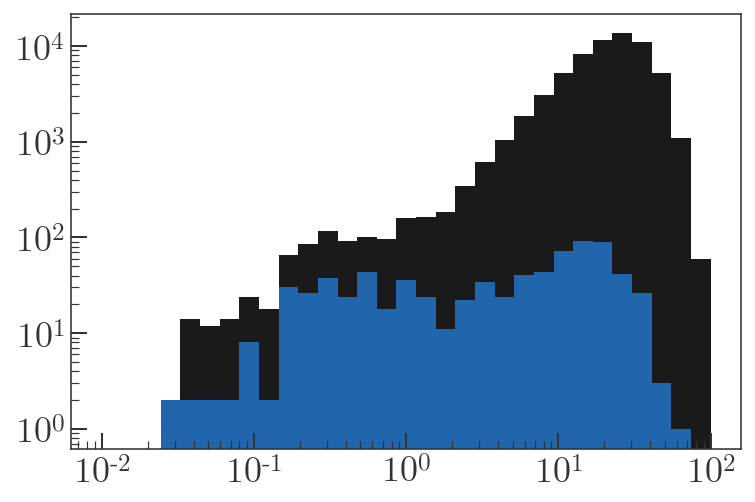

In [179]:
_,bins,_ = plt.hist(bright_sep2d.to(u.arcmin).value, 
                    bins=np.logspace(-2, 2, 32));

plt.hist(bright_sep2d.to(u.arcmin).value[bright_dist3d < 1*u.pc], 
         bins=bins);

plt.xscale('log')
plt.yscale('log')

In [184]:
star1 = bright_stars[bright_idx][(bright_sep2d > 1*u.arcmin) &
                                 (bright_sep2d < 2*u.arcmin) & 
                                 (bright_dist3d < 1*u.pc)]
star2 = bright_stars[(bright_sep2d > 1*u.arcmin) & 
                     (bright_sep2d < 2*u.arcmin) & 
                     (bright_dist3d < 1*u.pc)]

len(star1)

45

In [186]:
for i in range(0, len(star1), 2):
    row1 = star1[i]
    row2 = star2[i]
    
    cs = []
    for row in [row1, row2]:
        c = coord.ICRS(ra=row['ra']*u.deg, dec=row['dec']*u.deg, 
                       distance=1000/row['parallax']*u.pc,
                       pm_ra_cosdec=row['pmra']*u.mas/u.yr,
                       pm_dec=row['pmdec']*u.mas/u.yr)
        cs.append(c)
    
    dpm = np.sqrt((cs[0].pm_ra_cosdec-cs[1].pm_ra_cosdec)**2 +
                  (cs[0].pm_dec-cs[1].pm_dec)**2)
    dv = (c.distance * dpm).to(u.km/u.s, u.dimensionless_angles())
    dx = (cs[0].separation(cs[1]) * cs[0].distance).to(u.pc, u.dimensionless_angles())
    
    print("∆x_sky = {0:.3f} \n∆v = {1:.2f}\n".format(dx, dv))

∆x_sky = 0.036 pc 
∆v = 0.47 km / s

∆x_sky = 0.028 pc 
∆v = 8.75 km / s

∆x_sky = 0.021 pc 
∆v = 0.44 km / s

∆x_sky = 0.010 pc 
∆v = 1.02 km / s

∆x_sky = 0.003 pc 
∆v = 0.80 km / s

∆x_sky = 0.023 pc 
∆v = 0.27 km / s

∆x_sky = 0.016 pc 
∆v = 0.36 km / s

∆x_sky = 0.065 pc 
∆v = 0.14 km / s

∆x_sky = 0.017 pc 
∆v = 0.70 km / s

∆x_sky = 0.083 pc 
∆v = 17.30 km / s

∆x_sky = 0.070 pc 
∆v = 62.10 km / s

∆x_sky = 0.023 pc 
∆v = 0.27 km / s

∆x_sky = 0.024 pc 
∆v = 0.28 km / s

∆x_sky = 0.038 pc 
∆v = 0.31 km / s

∆x_sky = 0.043 pc 
∆v = 0.48 km / s

∆x_sky = 0.023 pc 
∆v = 0.40 km / s

∆x_sky = 0.020 pc 
∆v = 0.27 km / s

∆x_sky = 0.029 pc 
∆v = 0.63 km / s

∆x_sky = 0.053 pc 
∆v = 0.27 km / s

∆x_sky = 0.010 pc 
∆v = 1.65 km / s

∆x_sky = 0.043 pc 
∆v = 1.12 km / s

∆x_sky = 0.039 pc 
∆v = 0.23 km / s

∆x_sky = 0.030 pc 
∆v = 0.93 km / s

